# MNIST training



In [9]:
import numpy as onp
import jax.numpy as jnp
import losses

from training import train
from custom_activations import smooth_leaky_relu
#from tb_logger import tensorboard_decorator
from loggers import *
from utils import *
from datasets.dataloaders import load_dataset

### Setting hyperparameters and loading the dataset

In [12]:
# hyperparameters
seed       = 42
num_layers = 2

batch_size = 10
epochs     = 25

lr         = 1e-4

bias       = True
trick      = True
#generate   = True

dataset    = "MNIST"
log_dir    = "mnist_run/"

alpha      = 0.01
activation = lambda x: smooth_leaky_relu(x, alpha=alpha)
loss_pdf   = losses.log_pdf_normal

# Load dataset
train_data, val_data, test_data, transform = load_dataset(dataset)

### Model definition

A model is specified by its `params` and 3 `g` functions. All the 3 functions perform a forward pass through the model, but with some differences:
* `g_dummy` takes 3 arguments: `params`, `dummy_params`, `data`. The `dummy_params` are there only to be able to accumulate the `delta` gradients when needed (refer to Section D of the Supplementary Material).
* `g_layerwise` returns the output `z` (the predicted sources) and the activations `ys` for each layer (no non-linearities applied).
* `g`: returns `z` only

The model constructors are found in `models.py`.

In [8]:
import models

d = train_data.shape[-1] # data dimensionality

# model definition ############################################################
params, g_dummy, g_layerwise, g = models.g_with_dummies(d, num_layers,
                                             activation = activation,
                                             seed = seed,
                                             batch_size = batch_size,
                                             bias = bias)

### Loss function and gradient computation

In [10]:
# The loss function requires the `g_dummy` model in order to be able to compute
# the gradients of the `delta` terms (Section D of the Supplementary Material)

loss = losses.get_loss_deltas(g_dummy, loss_pdf, activation = activation)
gradient = losses.natural_grad_deltas(loss, activation, bias=bias, trick=trick)

# When we use biases, we need to project the gradient on the appropriate submanifold
# (refer to Section F of the Supplementary Material)

if bias:
    gradient = gradient_padding(gradient)
    
    
# Logging loss values and execution time ############################################
log_losses_ = losses.losses_logger(loss, loss_pdf, val_data, activation, g_layerwise)

loss_vs_time = []

def log_loss(params, epoch):
    _, v = log_losses_(params, epoch)
    l = v[3]
    loss_vs_time.append(l)
    return "Loss", [l]

log_time = timer()
log_params, get_params = params_getter(params)

loggers_list = [log_loss, log_time]

## Training

In [6]:
train(params, train_data, gradient,
      epochs = epochs,
      lr = lr,
      batch_size = batch_size,
      loggers = loggers_list,
      log_every = 1
     )

Epoch 0 [Loss [1404.8104248046875]] [Time [60.657156933040824]] 
Epoch 1 [Loss [1381.4111328125]] [Time [58.29753472498851]] 
Epoch 2 [Loss [1374.9918212890625]] [Time [58.91373840399319]] 
Epoch 3 [Loss [1372.2982177734375]] [Time [59.64869629900204]] 
Epoch 4 [Loss [1371.12646484375]] [Time [59.480004040000495]] 
Epoch 5 [Loss [1370.330810546875]] [Time [58.69616854301421]] 
Epoch 6 [Loss [1369.85205078125]] [Time [58.221025504986756]] 
Epoch 7 [Loss [1369.617431640625]] [Time [58.67217283899663]] 
Epoch 8 [Loss [1368.893798828125]] [Time [59.51819232001435]] 
Epoch 9 [Loss [1368.841796875]] [Time [58.65609293297166]] 
Epoch 10 [Loss [1368.6226806640625]] [Time [58.873983016994316]] 
Epoch 11 [Loss [1368.42529296875]] [Time [59.738252012990415]] 
Epoch 12 [Loss [1368.574951171875]] [Time [59.52137082599802]] 
Epoch 13 [Loss [1368.4102783203125]] [Time [56.67055111605441]] 
Epoch 14 [Loss [1368.41943359375]] [Time [57.885606968950015]] 
Epoch 15 [Loss [1368.22412109375]] [Time [59.274

0

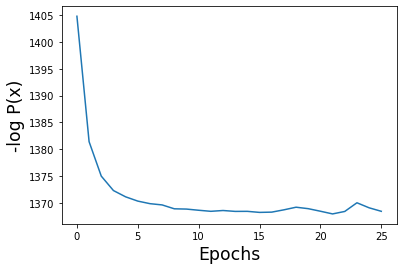

In [31]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.set_ylabel('-log P(x)', fontsize='xx-large')
ax.set_xlabel('Epochs', fontsize='xx-large')
plt.plot(loss_vs_time)
plt.show()